<a href="https://colab.research.google.com/github/replacementAI/Finding-Alpha-with-AI/blob/main/Step_1_Evaluating_Different_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (7, 7)

2. Define functions to load data, create features

In [2]:
def csv_loader(path, index_col=True, flip=True):
    if index_col:
        df = pd.read_csv(path, index_col=0, parse_dates=True) 
    else: df = pd.read_csv(path)
    if flip:
        df = df.iloc[::-1]
    return df

def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['LastClose'] = df['Close'].shift(periods=1)
    df['Gap'] = df['Open'] - df['LastClose']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'LastClose',
                     'Gap',
                     ],
            inplace=True)
    
    df.drop(columns=['Open','High','Low','Close','Volume',
                     #'Adj Close'
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    lookback += 1
    for i in range(step, lookback, step):
        df['%d Max' % (i)] = df['High'].rolling(window=i).max()
        df['%d Max' % (i)] = df['%d Max' % (i)].pct_change(fill_method=None)
        df['%d Min' % (i)] = df['Low'].rolling(window=i).min()
        df['%d Min' % (i)] = df['%d Min' % (i)].pct_change(fill_method=None)

        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Rolling Avg Open' % (i)] = df['Open'].rolling(window=i).mean()
        df['%d Rolling Avg Open' % (i)] = df['%d Rolling Avg Open' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg High' % (i)] = df['High'].rolling(window=i).mean()
        df['%d Rolling Avg High' % (i)] = df['%d Rolling Avg High' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg Low' % (i)] = df['Low'].rolling(window=i).mean()
        df['%d Rolling Avg Low' % (i)] = df['%d Rolling Avg Low' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg Close' % (i)] = df['Close'].rolling(window=i).mean()
        df['%d Rolling Avg Close' % (i)] = df['%d Rolling Avg Close' % (i)].pct_change(fill_method=None)
    return df
  
def features(df, lookback, step):
    create_features(df)
    process_features(df, lookback, step)
    drop_features(df)
    return df

3. Create a function to create a target.

In [3]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

**Why create a seperate target instead of using the open or close price?** 

Because the price of the stock is always changing. For example, the model creates a rule to buy at 20 and sell at 30. What if the stock price goes above 30? 

**The model can see all the data so it will know what to do if it goes to a higher price.** 

What if the stock we are creating a strategy on reaches a new high, or a new low? Then the model won't know what to do. We need to scale the data in a way that doesn't make any assumptions. We will log normalize the open or close (you can pick) price and use that as our target.

4. Define the models we are going to use

We are going to use regularized linear models since they have a built in function that allows them to pick which features to keep or remove, and we are going to add a nearest neighbor model just to mix it up.

In [8]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = ElasticNet(alpha=.001)
estimator4 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3,estimator4]

5. Define the parameters and the dataframe where we will store our results

Make sure that step is less than lookback. Our step is the interval of how many periods back we are going to creatures from, and lookback is how far back we will create features. 

In [9]:
lookforward = 2
step = 21
lookback = 21

results = pd.DataFrame()

6. Import the data we are going to use, pick which stock we are going to use as a target, and create features from it. Then drop all NaNs and clean the data. Then split the data in half.

In [10]:
for model in models:
    if lookback >= step:
        spy = csv_loader(path='/content/SPY.csv', index_col=True, flip=False)
        agg = csv_loader(path='/content/AGG.csv', index_col=True, flip=False)

        spy = create_target(spy, lookforward, target='Open')

        spy = features(spy, lookback, step)
        spy = spy.add_suffix(' SPY')
        agg = features(agg, lookback, step)
        agg = agg.add_suffix(' AGG')
        cv = pd.merge(spy, agg, how='inner', on='Date')

        cv.drop(cv.tail(lookforward).index, inplace=True)
        cv.drop(cv.head(lookback).index, inplace=True)
        X = cv
        y = X[['Target SPY']]
        X = X.drop(columns=['Target SPY'])
        X.fillna(method="ffill", inplace=True)
        X.replace([np.inf, -np.inf], 0, inplace=True)
        X.fillna(0, inplace=True)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model] = y_pred.flatten()

    else:
        print('Lookback must be greater than or equal to step')
        break

7. Visualize the correlation of the models

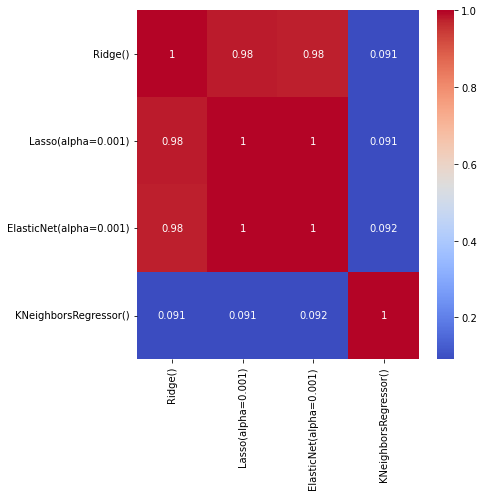

In [11]:
correlation = results.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

Here we can see that ElasticNet and Lasso are correlated 1 to 1, which is odd considering they are slightly different. Why do we want uncorrelated models (correlations as close to 0 as possible)? Because when we have uncorrelated models, each model has its own strategy to maximize the scoring function, and when we combine all these uncorrelated strategies, we get a meta-strategy or meta-model which has a robust strategy.

In the next notebook we will evaluate the performance of the meta-model vs different lookbacks and step intervals.